
# Sentiment Analysis on Customer Reviews
This project performs sentiment analysis on consumer product reviews to determine whether each review expresses a positive or negative sentiment. 
The analysis leverages different text classification models, including Naive Bayes, XGBoost, and HuggingFace Transformers. By comparing these approaches, we aim to identify the model that provides the most accurate predictions on unseen review data.

**Workflow Overview**:
1. Data Cleaning and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Text Vectorization
4. Model Training and Evaluation


<a id='imp'></a>
# Importing packages and loading data

In [1]:
# required libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset 
df = pd.read_csv(r"C:/zshahpouri/data/1429_1/1429_1.csv")
df.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


<a id='eda'></a>
# Exploratory Data Analysis (EDA)


Since we are interested in sentiment analysis, we will only use `reviews.text` and `reviews.rating`

### Sample the Data: 
we use a random subset of 10000 rows for better performance, reduce memory usage.
fixed seed makes our choices reproducible.

In [3]:

data = df[["reviews.text","reviews.rating"]].sample(20000,random_state=23)
data.head()

,reviews.text,reviews.rating
21536,Bought as a Mother's Day Gift. This is great f...,4.0
20669,I can hold this next to my Kindle Paperwhite a...,5.0
30656,Love this device and went on to buy 2 as gifts...,5.0
25297,"With some technical savvy, you can quickly hav...",5.0
9016,bought for grandkids they love them. wise choi...,5.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 21536 to 22132
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    20000 non-null  object 
 1   reviews.rating  19983 non-null  float64
dtypes: float64(1), object(1)
memory usage: 468.8+ KB


In [5]:
# drop missing values
data.dropna(inplace=True)
data.isnull().sum()

reviews.text      0
reviews.rating    0
dtype: int64

In [6]:
# descriptive statistics
data.describe()

,reviews.rating
count,19983.000000
mean,4.586899
std,0.735887
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
# distribution of rating
data['reviews.rating'].value_counts().sort_index(ascending=False)

reviews.rating
5.0    13763
4.0     4898
3.0      849
2.0      233
1.0      240
Name: count, dtype: int64

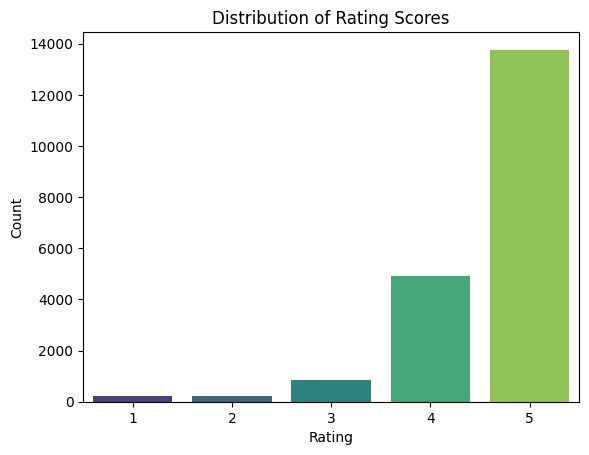

In [8]:
# Drop NaNs if they exist
data = data.dropna(subset=['reviews.rating'])

# Convert to integers
data['reviews.rating'] = data['reviews.rating'].astype(int)
sns.countplot(data=data, x='reviews.rating', palette='viridis')
plt.title('Distribution of Rating Scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [9]:
data5 = data[data['reviews.rating']==5].sample(1000,random_state=43)
data4 = data[data['reviews.rating']==4].sample(1000,random_state=43)
data3 = data[data['reviews.rating']==3]
data2 = data[data['reviews.rating']==2]
data1 = data[data['reviews.rating']==1]

data = pd.concat([data5,data4,data3,data2,data1])
data['reviews.rating'].value_counts().sort_index(ascending=False)

reviews.rating
5    1000
4    1000
3     849
2     233
1     240
Name: count, dtype: int64

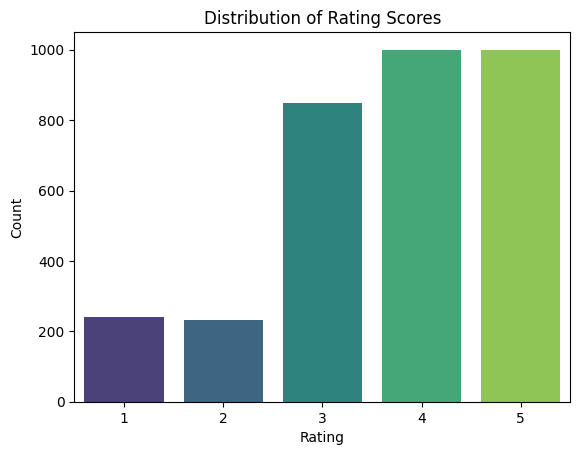

In [10]:
# Drop NaNs if they exist
data = data.dropna(subset=['reviews.rating'])

# Convert to integers
data['reviews.rating'] = data['reviews.rating'].astype(int)
sns.countplot(data=data, x='reviews.rating', palette='viridis')
plt.title('Distribution of Rating Scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [11]:
# Define the new mappings
sentiment_score = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2} 
sentiment = {0: 'NEGATIVE', 1: 'SOSO', 2: 'POSITIVE'}

# mapping
data['sentiment_score'] = data['reviews.rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)

data.head()

,reviews.text,reviews.rating,sentiment_score,sentiment
31354,This is the best alternative to cable. Very ea...,5,2,POSITIVE
33776,For the price Amazon tv is the best everything...,5,2,POSITIVE
32587,The item works great wish the speeds were fast...,5,2,POSITIVE
29180,This is one of the coolest new inventions arou...,5,2,POSITIVE
2154,"So much better than my previous kindle, I've u...",5,2,POSITIVE


In [12]:
data['sentiment_score'].value_counts()

sentiment_score
2    2000
1     849
0     473
Name: count, dtype: int64

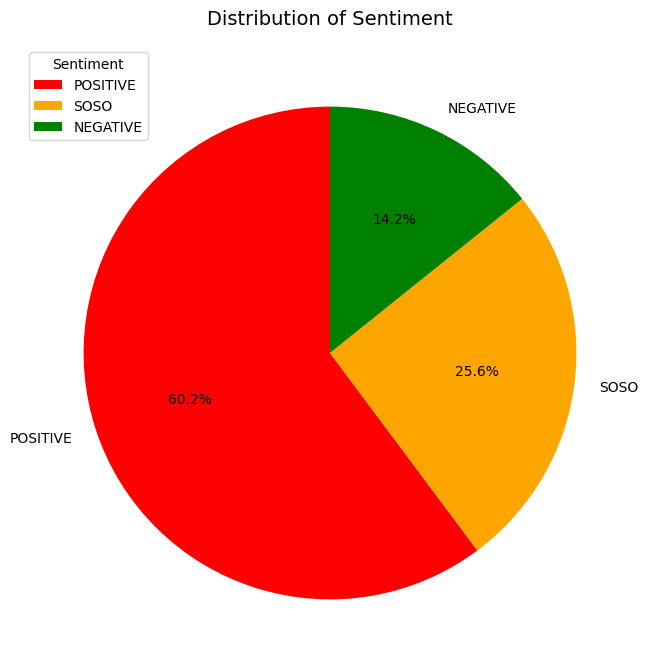

In [13]:
# Distribution of sentiment
plt.figure(figsize=(8, 8))

# Get sentiment counts and labels
sentiment_counts = data['sentiment'].value_counts()
labels = sentiment_counts.index  # Use the sentiment names
sizes = sentiment_counts.values  # Use the sentiment counts

# Pie chart with labels and legend
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%',  # Display percentages
    startangle=90,      # Start angle for better visualization
    colors=['red', 'orange', 'green']  # Optional: custom colors
)

plt.title('Distribution of Sentiment', size=14, y=1.02)
plt.legend(labels=labels, title="Sentiment", loc="upper left")
plt.show()

----------

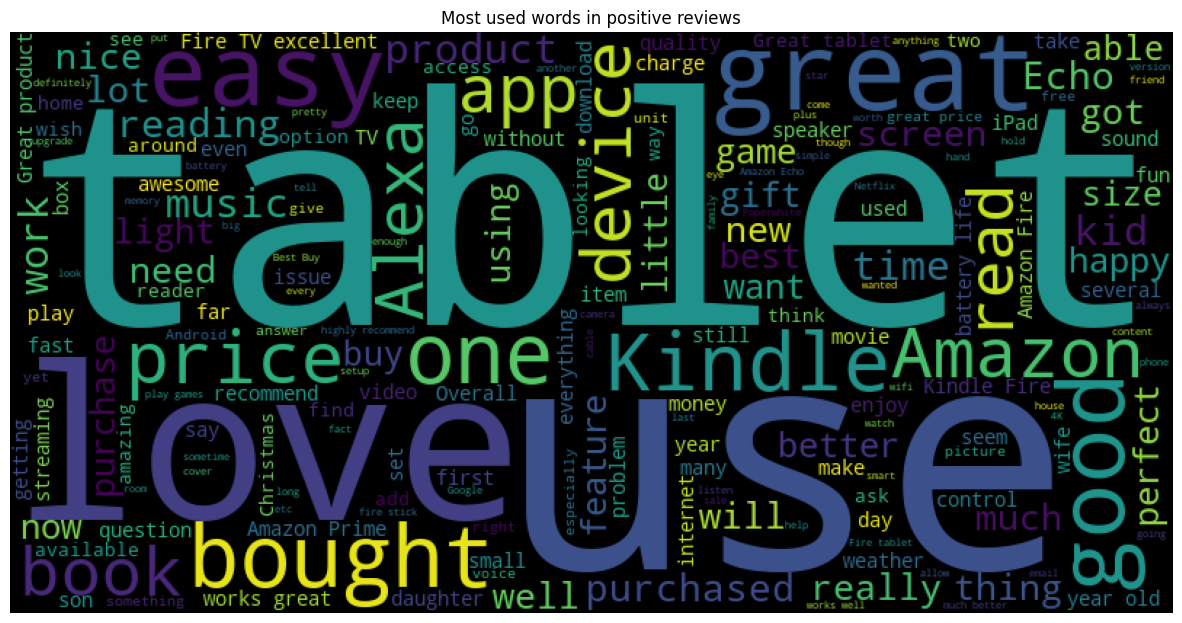

In [14]:
positiveWords = pd.Series(' '.join(data[data['sentiment']=='POSITIVE']['reviews.text']).split())
# plot word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, width = 800, height = 400).generate(' '.join(positiveWords))


plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positive reviews")

plt.axis("off")
plt.show()

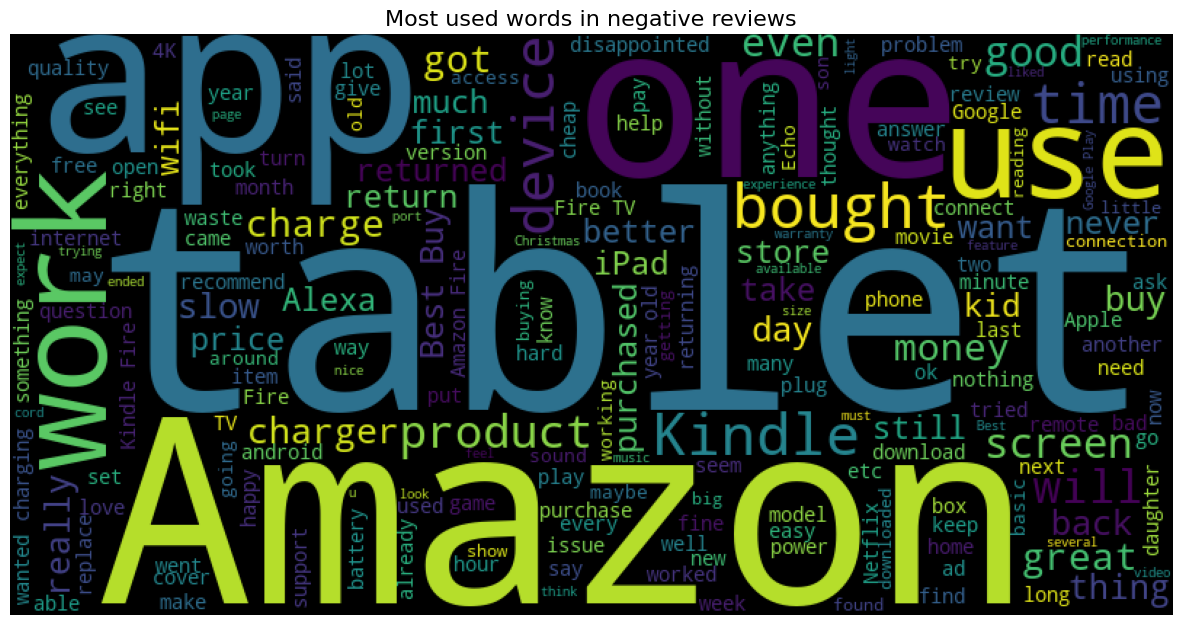

In [15]:
negativeWords = pd.Series(' '.join(data[data['sentiment']=='NEGATIVE']['reviews.text']).split())
# plot word cloud
wordcloud = WordCloud(stopwords=STOPWORDS,width = 800, height = 400).generate(' '.join(negativeWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

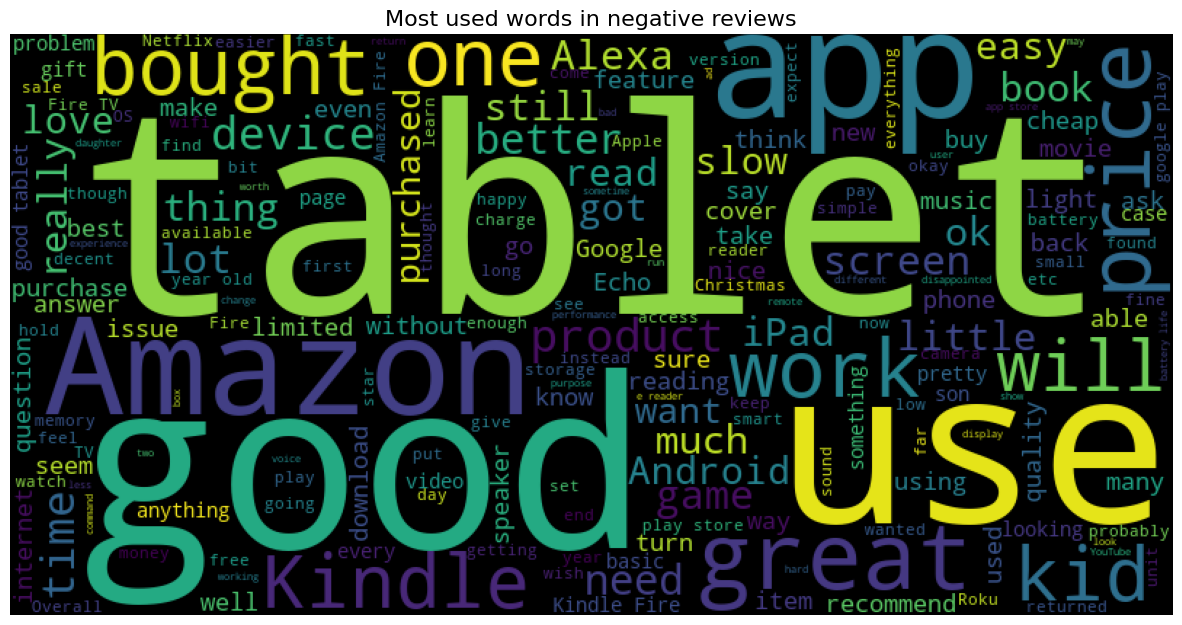

In [16]:
sosoWords = pd.Series(' '.join(data[data['sentiment']=='SOSO']['reviews.text']).split())
# plot word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, width = 800, height = 400).generate(' '.join(sosoWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

-------------

<a id='pro'></a>
# Text Processing

## Clleaning the text

We can also do this using SpaCy.

In [17]:
import re
import spacy

# Load SpaCy's language model
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    """
    Clean text by applying various preprocessing steps:
    - Convert to lowercase
    - Remove HTML tags
    - Replace numbers with a placeholder
    - Remove punctuation
    - Remove extra spaces and tabs
    - Remove stopwords using SpaCy
    """
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Replace numbers with a space
    text = re.sub(r'\d+', ' ', text)

    # Replace punctuation with a space
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace and tabs
    text = re.sub(r'\s+', ' ', text).strip()

    # Process the text with SpaCy for stopword removal
    doc = nlp(text)
    cleaned_text = " ".join([token.text for token in doc if not token.is_stop])

    return cleaned_text

# Example usage
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(clean_text(text))


message cleaned involve things like adjacent spaces tabs



### 2. Removing Stopwords
Words don't contribute too much to the overall meaning of the sentences. For example: "a", "an", "the", "this", "that", "is", "it", "to", "and".

We can remove stopwords using SpaCy or NLTK, both of which have built-in stopword lists.

In [18]:
# Load SpaCy language model
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    # Process the text using SpaCy
    doc = nlp(text)
    
    # Filter out stopwords
    filtered_words = [token.text for token in doc if not token.is_stop]
    cleaned_text = " ".join(filtered_words)
    
    return cleaned_text

# nlp.Defaults.stop_words.add("custom_stopword")
# nlp.vocab["custom_stopword"].is_stop = True
# stop_words.add("custom_stopword")      # Add a word to stopwords
# stop_words.remove("not_stopword")      # Remove a word from stopwords

text = "This is an example sentence to demonstrate stopword removal."

# Using SpaCy
print(remove_stopwords(text))

example sentence demonstrate stopword removal .


## 3. Stemming or lemmatization
Stemming is a rule-based system to convert words into their root form. It removes suffixes from words. This helps us enhace similarities (if any) between sentences. 

Example:
"cleaning", "cleaned" -> "clean"

For stemming text, you can use either NLTK or SpaCy with custom modifications. 

Option 1: NLTK using SnowballStemmer
Option 2: SpaCy using Lemmatization (a more refined approach)


In [19]:
def lemmatize_text(text):
    """
    Lemmatize text using SpaCy.
    """
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

# Example usage
text = "Running quickly through the streets, they were amazed by the results."
print(lemmatize_text(text))


run quickly through the street , they be amazed by the result .


### Apply all text processing functions 

In [20]:
# clean text
data['text'] = data['reviews.text'].apply(clean_text)
# remove stopwords
data['text'] = data['text'].apply(remove_stopwords)
# lemmatize
data['text'] = data['text'].apply(lemmatize_text)

In [21]:
# check some processed reviews
import random

i = random.choice(range(len(data)))

print(f"Original review: \n{data['reviews.text'].iloc[i]}\n")
print(f"Processed review: \n{data['text'].iloc[i]}") 

Original review: 
Easy to use and has a lot of games and books available. Good memory and you can't beat the price!

Processed review: 
easy use lot game book available good memory t beat price


In [22]:
# export cleaned data to csv
data.to_csv('cleaned_data.csv', index=False)

In [23]:
data = pd.read_csv('cleaned_data.csv')
data.head(2)

,reviews.text,reviews.rating,sentiment_score,sentiment,text
0,This is the best alternative to cable. Very ea...,5,2,POSITIVE,good alternative cable easy use
1,For the price Amazon tv is the best everything...,5,2,POSITIVE,price amazon tv good watch come k definitely r...


In [24]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3321 entries, 0 to 3321
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviews.text     3321 non-null   object
 1   reviews.rating   3321 non-null   int64 
 2   sentiment_score  3321 non-null   int64 
 3   sentiment        3321 non-null   object
 4   text             3321 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


<a id='fe'></a>
# Feature Engineering and Selection

In [25]:
data.columns

Index(['reviews.text', 'reviews.rating', 'sentiment_score', 'sentiment',
       'text'],
      dtype='object')

Naive Bayes Model Performance
Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.58      0.65       383
        True       0.77      0.88      0.82       614

    accuracy                           0.76       997
   macro avg       0.76      0.73      0.74       997
weighted avg       0.76      0.76      0.76       997

Confusion Matrix:
 [[222 161]
 [ 74 540]]
Acuracy score:
 0.7642928786359077
AUC  0.7295566460567608


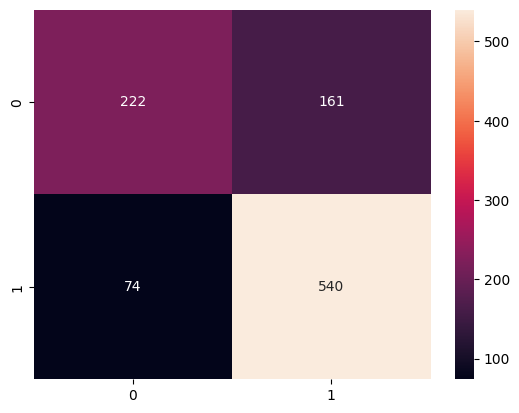

________________

XGBoost Model Performance
Classification Report:
               precision    recall  f1-score   support

       False       0.69      0.66      0.67       383
        True       0.79      0.81      0.80       614

    accuracy                           0.76       997
   macro avg       0.74      0.74      0.74       997
weighted avg       0.75      0.76      0.75       997

Confusion Matrix:
 [[253 130]
 [114 500]]
Acuracy score:
 0.7552657973921765
AUC  0.7374533300448203


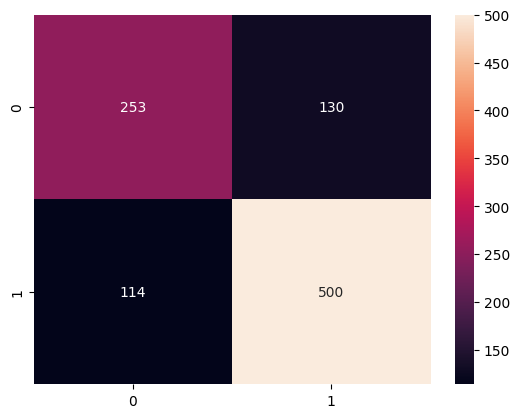

________________



In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['reviews.text'], data['reviews.rating'] > 3, test_size=0.3, random_state=42)

# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_features=700)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train and evaluate model function
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Acuracy score:\n", accuracy_score(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.show()
    print("________________\n")

# Naive Bayes Model Training and Evaluation
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
print("Naive Bayes Model Performance")
train_and_evaluate(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

# XGBoost Model Training and Evaluation
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
print("XGBoost Model Performance")
train_and_evaluate(xgb_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['reviews.text'], 
    data['sentiment_score'], 
    test_size=0.3, 
    random_state=42
)


In [28]:
# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_features=700)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Naive Bayes Model Performance
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.88      0.14      0.24       150
        SOSO       0.50      0.26      0.34       233
    POSITIVE       0.69      0.96      0.81       614

    accuracy                           0.67       997
   macro avg       0.69      0.45      0.46       997
weighted avg       0.68      0.67      0.61       997

Confusion Matrix:
 [[ 21  40  89]
 [  1  61 171]
 [  2  22 590]]
Accuracy Score:
 0.6740220661985958


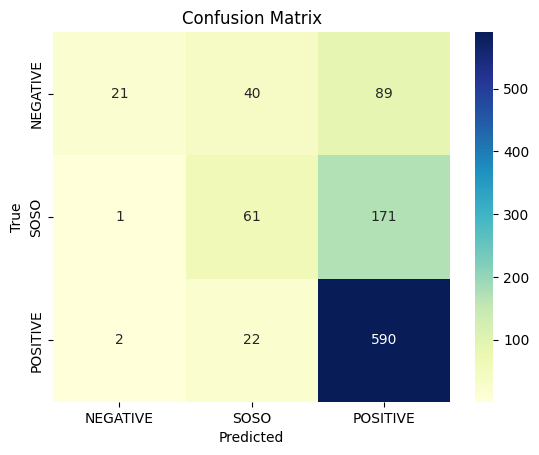

________________



In [29]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['NEGATIVE', 'SOSO', 'POSITIVE']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Accuracy Score:\n", accuracy_score(y_test, y_pred))
    
    # Heatmap for the confusion matrix
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        annot=True, 
        fmt="d", 
        cmap="YlGnBu", 
        xticklabels=['NEGATIVE', 'SOSO', 'POSITIVE'], 
        yticklabels=['NEGATIVE', 'SOSO', 'POSITIVE']
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print("________________\n")


# Train and evaluate Naive Bayes model
nb_model = MultinomialNB()
print("Naive Bayes Model Performance")
train_and_evaluate(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)
grid_search.fit(X_train_tfidf, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)



Fitting 3 folds for each of 108 candidates, totalling 324 fits
